In [1]:
from os.path import join
import numpy as np
from scipy import stats
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style

In [3]:
style.use(join("..", "style.mplstyle"))

In [4]:
posterior = xr.load_dataset("../model-results/posterior.nc")
posterior

<xarray.Dataset> Size: 126MB
Dimensions:                (draw: 8000, chain: 16, X*_dim_0: 3, X*_dim_1: 6,
                            sigma abundance_dim_0: 3, sigma abundance_dim_1: 6,
                            sigma d13C_dim_0: 3, sigma d13C_dim_1: 6,
                            X_dim_0: 3, X_dim_1: 6, M_dim_0: 3, M_dim_1: 6,
                            C_dim_0: 3, C_dim_1: 6, F_dim_0: 3, F_dim_1: 3,
                            Methane Index_dim_0: 3, Methane Index_dim_1: 1,
                            D_dim_0: 3)
Coordinates: (12/19)
  * draw                   (draw) int32 32kB 0 1 2 3 4 ... 7996 7997 7998 7999
  * chain                  (chain) int32 64B 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * X*_dim_1               (X*_dim_1) int32 24B 0 1 2 3 4 5
  * sigma abundance_dim_1  (sigma abundance_dim_1) int32 24B 0 1 2 3 4 5
  * sigma d13C_dim_1       (sigma d13C_dim_1) int32 24B 0 1 2 3 4 5
  * X_dim_1                (X_dim_1) int32 24B 0 1 2 3 4 5
    ...                     ...
  * sigma d13C_dim_0       (sigma d13C_dim_0) int32 12B 0 1 2
  * X_dim_0                (X_dim_0) int32 12B 0 1 2
  * M_dim_0                (M_dim_0) int32 12B 0 1 2
  * Methane Index_dim_0    (Methane Index_dim_0) int32 12B 0 1 2
  * C_dim_0                (C_dim_0) int32 12B 0 1 2
  * Methane Index_dim_1    (Methane Index_dim_1) int32 4B 0
Data variables:
    X*                     (chain, draw, X*_dim_0, X*_dim_1) float64 18MB 0.5...
    sigma abundance        (chain, draw, sigma abundance_dim_0, sigma abundance_dim_1) float64 18MB ...
    sigma d13C             (chain, draw, sigma d13C_dim_0, sigma d13C_dim_1) float64 18MB ...
    X                      (chain, draw, X_dim_0, X_dim_1) float64 18MB 0.459...
    M                      (chain, draw, M_dim_0, M_dim_1) float64 18MB 0.397...
    C                      (chain, draw, C_dim_0, C_dim_1) float64 18MB -49.6...
    F                      (chain, draw, F_dim_0, F_dim_1) float64 9MB 0.5138...
    Methane Index          (chain, draw, Methane Index_dim_0, Methane Index_dim_1) float64 3MB ...
    D                      (chain, draw, D_dim_0) float64 3MB -18.92 ... -29.14
Attributes:
    created_at:                 2024-02-27T03:12:13.984831
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              7322.326768159866
    tuning_steps:               2000

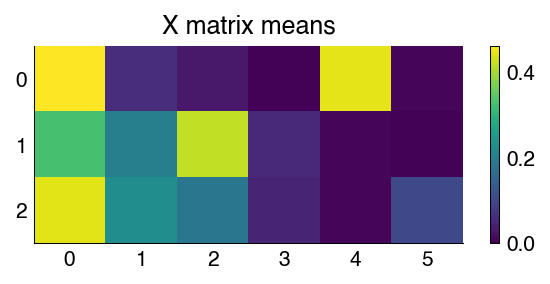

In [5]:
fig, ax = plt.subplots(figsize=(4, 2))
r = ax.pcolormesh(posterior["X"].mean(dim=("chain", "draw")).values, vmin=0)
ax.invert_yaxis()
plt.colorbar(r, ax=ax)
ax.set_title("X matrix means")
ax.set_yticks(np.linspace(0.5, 2.5, 3))
ax.set_yticklabels(np.arange(3))
ax.set_xticks(np.linspace(0.5, 5.5, 6))
ax.set_xticklabels(np.arange(6))
fig.tight_layout()

In [6]:
def peak(z, area, mu, sigma):
    return area * stats.norm(loc=mu, scale=sigma).pdf(z)

In [7]:
def peaks(z, area, mu, sigma):
    assert len(mu) == len(area)
    return sum(peak(z, area[i], mu[i], sigma) for i in range(len(mu)))

In [8]:
def synthetic_peaks(ax, X, locs, sigma=1):
    assert X.ndim == 2
    assert len(locs) == X.shape[0] == 6
    z = np.linspace(np.min(locs) - 2 * sigma, np.max(locs) + 2 * sigma, 2001)
    ax.fill_between(
        z,
        peaks(z, np.quantile(X, 0.01, axis=1), locs, sigma),
        peaks(z, np.quantile(X, 0.99, axis=1), locs, sigma),
        color="C0",
        linewidth=0.5,
        alpha=0.2,
        label="99th percentile",
    )
    ax.fill_between(
        z,
        peaks(z, np.quantile(X, 0.25, axis=1), locs, sigma),
        peaks(z, np.quantile(X, 0.75, axis=1), locs, sigma),
        color="C1",
        linewidth=0.5,
        alpha=0.6,
        label="25th percentile",
    )
    ax.plot(
        z,
        peaks(z, X.mean(axis=1), locs, sigma),
        color="k",
        linewidth=1,
        label="mean",
    )
    return None

In [9]:
times = np.linspace(0, 1, 6)
GDGTs = ["G0", "G1", "G2", "G3", "Cren", "Cren regio"]
communities = ["planktonic\nautotrophic", "methanotrophic", "benthic"]

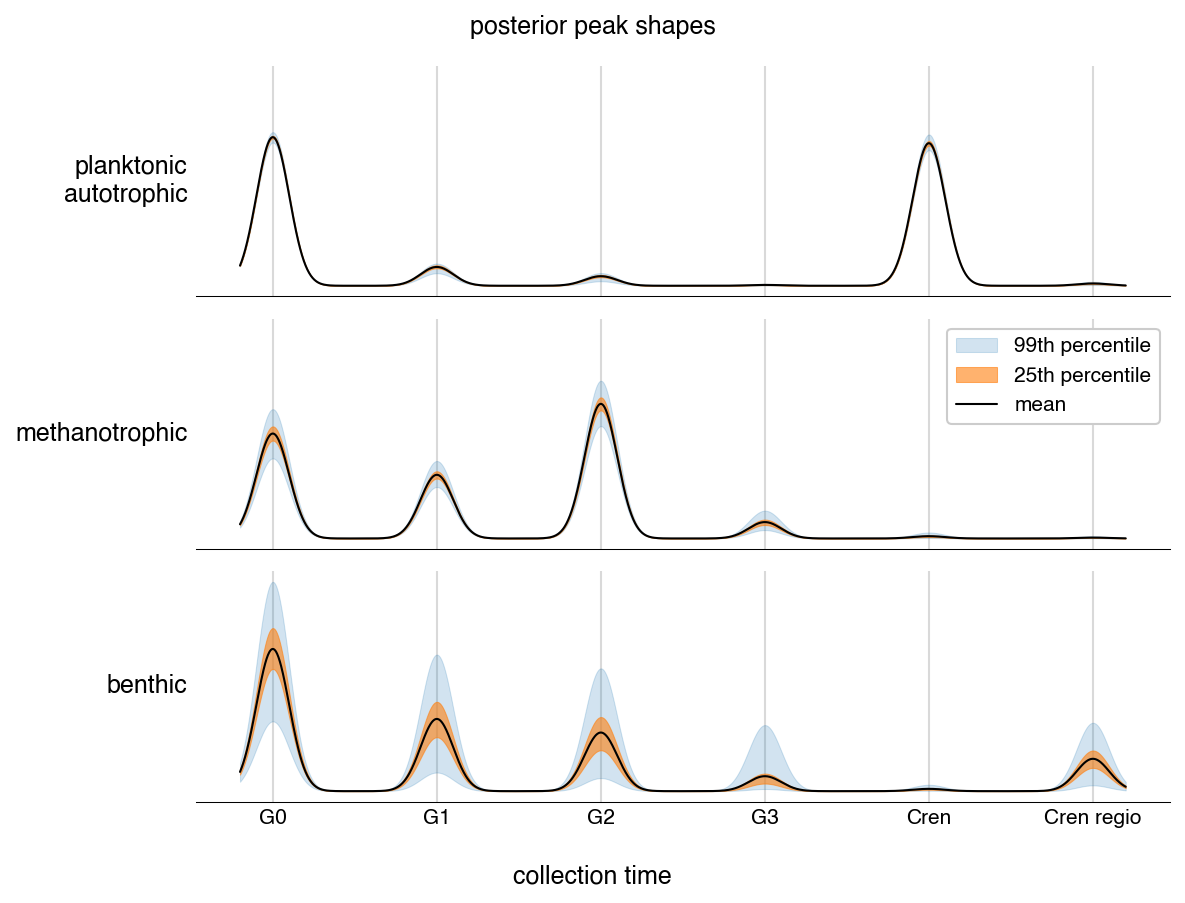

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)
for i in range(3):
    X = posterior["X"].stack(sample=("chain", "draw")).values[i, ...]
    synthetic_peaks(axs[i], X, times, 0.02)
    for t in times:
        axs[i].axvline(t, alpha=0.15, color="k", linewidth=1, zorder=-1)
    axs[i].set_yticks([])
    axs[i].grid(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].set_ylabel(communities[i], rotation=0, ha="right", va="center")
axs[1].legend()
axs[2].set_xticks(times)
axs[2].set_xticklabels(GDGTs)
fig.supxlabel("collection time")
fig.suptitle("posterior peak shapes")
fig.tight_layout()